# Point cloud segmentation

## Imports

In [38]:
import open3d as o3d
import sys
import numpy as np
from sklearn.linear_model import RANSACRegressor
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Loading in the data

In [5]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/cube1.ply")
pcd.paint_uniform_color([0.9, 0.9, 0.9])
points = np.asarray(pcd.points)

## RANSAC
### SciKit Learn

In [6]:
# Fit a plane to the point cloud
ransac = RANSACRegressor(min_samples=3, residual_threshold=0.01, max_trials=1000)
ransac.fit(points[:, :2], points[:, 2])

# Get the inlier points
inlier_mask = ransac.inlier_mask_
inlier_points = points[inlier_mask, :]

# Get the outlier points
outlier_mask = np.logical_not(ransac.inlier_mask_)
outlier_points = points[outlier_mask, :]

# Get the plane parameters
plane = ransac.estimator_.coef_
plane = np.append(plane, ransac.estimator_.intercept_)

In [7]:
# Create a new point cloud with only the inlier points
inlier_pcd = o3d.geometry.PointCloud()
inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points)
inlier_pcd.paint_uniform_color([0.9, 0, 0])

# Create a new point cloud with only the outlier points
outlier_pcd = o3d.geometry.PointCloud()
outlier_pcd.points = o3d.utility.Vector3dVector(outlier_points)
outlier_pcd.paint_uniform_color([0, 0.9, 0])

# Visualize the point cloud
o3d.visualization.draw_geometries([outlier_pcd, inlier_pcd])

### Open3D

In [8]:
# Use RANSAC to segment the plane
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

# Extract the inlier points
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])

# Extract the outlier points
outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 0, 1])

# Visualize the point cloud
o3d.visualization.draw_geometries([outlier_cloud, inlier_cloud])

We can see that the open3D implementation, instantly detects a plane whereas this is not the case with sci-kit learn. However tweaking the parameters of the sci-kit learn implementation can lead to a similar result. Using the sci-kit learn package may lead to better results in the future as it is more flexible and can be used for other algorithms.

## Finding all planes

Now we are going to loop the algorithm over the entire point cloud and find all planes. We will try both the sci-kit learn and open3D implementations.

### SciKit Learn

In [16]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/cube1.ply")
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

planes = []

# Fit a plane to the point cloud
ransac = RANSACRegressor(min_samples=3, residual_threshold=0.01, max_trials=1000)
ransac.fit(points[:, :2], points[:, 2])

# Get the inlier points
inlier_mask = ransac.inlier_mask_
inlier_points = points[inlier_mask, :]

# Get the outlier points
outlier_mask = np.logical_not(ransac.inlier_mask_)
outlier_points = points[outlier_mask, :]

# Create a new point cloud with only the inlier points
inlier_pcd = o3d.geometry.PointCloud()
inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points)
inlier_pcd.paint_uniform_color([0.9, 0, 0])

# Add the plane to the list of planes
planes.append(inlier_pcd)

# Repeat until there are no more points
# while len(outlier_points) > 0:
# Fit a plane to the point cloud
ransac = RANSACRegressor(min_samples=3, residual_threshold=0.01, max_trials=1000)
ransac.fit(outlier_points[:, :2], outlier_points[:, 2])

# Get the inlier points
inlier_mask = ransac.inlier_mask_
inlier_points = outlier_points[inlier_mask, :]

# Get the outlier points
outlier_mask = np.logical_not(ransac.inlier_mask_)
outlier_points = outlier_points[outlier_mask, :]

# Create a new point cloud with only the inlier points
inlier_pcd = o3d.geometry.PointCloud()
inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points)
inlier_pcd.paint_uniform_color([0, 0.9, 0])

# Add the plane to the list of planes
planes.append(inlier_pcd)

ransac = RANSACRegressor(min_samples=3, residual_threshold=0.01, max_trials=1000)
ransac.fit(outlier_points[:, :2], outlier_points[:, 2])

# Get the inlier points
inlier_mask = ransac.inlier_mask_
inlier_points = outlier_points[inlier_mask, :]

# Get the outlier points
outlier_mask = np.logical_not(ransac.inlier_mask_)
outlier_points = outlier_points[outlier_mask, :]

# Create a new point cloud with only the inlier points
inlier_pcd = o3d.geometry.PointCloud()
inlier_pcd.points = o3d.utility.Vector3dVector(inlier_points)
inlier_pcd.paint_uniform_color([0, 0, 0.9])

# Create a new point cloud with only the outlier points
outlier_pcd = o3d.geometry.PointCloud()
outlier_pcd.points = o3d.utility.Vector3dVector(outlier_points)
outlier_pcd.paint_uniform_color([0.9, 0.9, 0])

# Add the plane to the list of planes
planes.append(inlier_pcd)
planes.append(outlier_pcd)

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)

In [17]:
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
import numpy as np
import open3d as o3d

def segment_planes(points, min_samples=3, residual_threshold=0.01, max_trials=1000, eps=0.05, min_samples_cluster=10):
    planes = []
    while points.shape[0] >= min_samples:
        # Fit a plane to the point cloud
        ransac = RANSACRegressor(min_samples=min_samples, residual_threshold=residual_threshold, max_trials=max_trials)
        ransac.fit(points[:, :2], points[:, 2])

        # Get the inlier points
        inlier_mask = ransac.inlier_mask_
        inlier_points = points[inlier_mask, :]

        # Get the outlier points
        outlier_mask = np.logical_not(inlier_mask)
        outlier_points = points[outlier_mask, :]

        # Perform DBSCAN clustering on inlier points
        clustering = DBSCAN(eps=eps, min_samples=min_samples_cluster).fit(inlier_points[:, :2])

        # Identify main plane cluster by finding largest cluster
        labels = clustering.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        main_label = unique_labels[np.argmax(counts)]

        # Extract points in main plane cluster
        main_cluster_points = inlier_points[labels == main_label]

        # Convert points to Open3D point cloud
        plane = o3d.geometry.PointCloud()
        plane.points = o3d.utility.Vector3dVector(main_cluster_points)

        # Add the plane to the list of planes
        planes.append(plane)

        # Update points to be the outlier points
        points = outlier_points

    return planes


In [20]:
pcd = o3d.io.read_point_cloud("../data/cube1.ply")

# Estimate normals for the point cloud
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Convert Open3D point cloud to NumPy array
points = np.asarray(pcd.points)

# Normalize the points
points = points - points.mean(axis=0)

# Segment the planes
planes = segment_planes(points)

# Paint the planes
for i, plane in enumerate(planes):
    plane.paint_uniform_color([i / len(planes), 0, 0])

print("Number of planes: {}".format(len(planes)))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)

Number of planes: 39


The SKlearn method is really not good at finding the planes.

### Open3D



In [21]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/cube1.ply")
planes = []

while len(pcd.points) > 0:
    # Use RANSAC to segment the plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    # Extract the inlier points
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])

    # Extract the outlier points
    pcd = pcd.select_by_index(inliers, invert=True)

    # Add the plane to the list of planes
    planes.append(inlier_cloud)

print(len(planes))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)


6


The open3D implementation is much easier to use, after tinkering with the parameters of the sci-kit learn implementation I was still unable to get the same results, therefore I will be using the open3D implementation for the rest of the notebook.

Let's try to use the open3D implementation to find all planes other point clouds.

In [22]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/cube4.ply")
planes = []

while len(pcd.points) > 0:
    # Use RANSAC to segment the plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    # Extract the inlier points
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])

    # Extract the outlier points
    pcd = pcd.select_by_index(inliers, invert=True)

    # Add the plane to the list of planes
    planes.append(inlier_cloud)

print(len(planes))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)

6
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [55]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/pyramid1.ply")
planes = []

while len(pcd.points) > 0:
    # Use RANSAC to segment the plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    # Extract the inlier points
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])

    # Extract the outlier points
    pcd = pcd.select_by_index(inliers, invert=True)

    # Add the plane to the list of planes
    planes.append(inlier_cloud)

print(len(planes))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)


5


In [4]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/noisy_cube2.ply")
planes = []

print(pcd.points)

# Preprocess the point cloud
pcd.voxel_down_sample(voxel_size=0.01)
pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd.remove_radius_outlier(nb_points=16, radius=0.05)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

while len(pcd.points) >= 3:
    # Use RANSAC to segment the plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    # Extract the inlier points
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])

    # Extract the outlier points
    pcd = pcd.select_by_index(inliers, invert=True)

    # Add the plane to the list of planes
    planes.append(inlier_cloud)

print(len(planes))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)


std::vector<Eigen::Vector3d> with 6000 elements.
Use numpy.asarray() to access data.
26


In [2]:
# Load in point cloud
pcd = o3d.io.read_point_cloud("../data/TLS_kitchen.ply")
planes = []

print(pcd.points)

# Preprocess the point cloud
pcd.voxel_down_sample(voxel_size=0.01)
pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd.remove_radius_outlier(nb_points=16, radius=0.05)
pcd.estimate_normals()


while len(pcd.points) >= 3:
    # Use RANSAC to segment the plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    # Extract the inlier points
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])

    # Extract the outlier points
    pcd = pcd.select_by_index(inliers, invert=True)

    # Add the plane to the list of planes
    planes.append(inlier_cloud)

print(len(planes))

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)


std::vector<Eigen::Vector3d> with 511026 elements.
Use numpy.asarray() to access data.
114
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


Even though there are a lot of planes that seem to be overlapping. All the selected planes do seem to be correct planes. Perhaps if we use a clustering algorithm to find the planes that are overlapping we can get a better result.

## PCA

Now lets take a look how Principal Component Analysis (PCA) can be used to find the planes in the point cloud. We will use the sci-kit learn implementation of PCA.

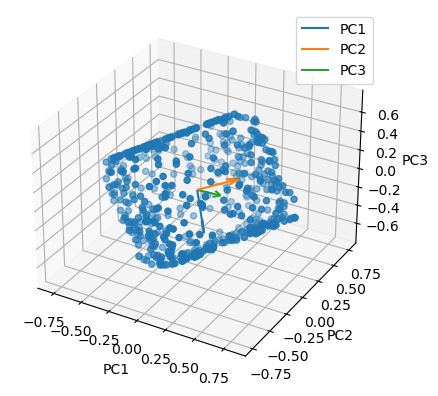

In [65]:
import open3d as o3d
import numpy as np
from sklearn.decomposition import PCA
import random

# Load the point cloud
pcd = o3d.io.read_point_cloud("../data/cube1.ply")

# Convert point cloud to 2D numpy array
points = np.asarray(pcd.points)

# Initialize PCA object
pca = PCA(n_components=3)

# Fit the PCA model to the data
pca.fit(points)

# Transform the data using the PCA model
transformed_data = pca.transform(points)

# Get the components of the PCA model
components = pca.components_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data and perform PCA as described in previous answer

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2])

# Plot principal components as vectors
origin = np.mean(transformed_data, axis=0)
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    end = origin + comp * np.sqrt(var)
    ax.quiver(origin[0], origin[1], origin[2], end[0]-origin[0], end[1]-origin[1], end[2]-origin[2], color=f'C{i}', label=f'PC{i+1}')

# Add labels and legend
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()


The principal component analysis does not seem to be able to find the planes in the point cloud.

## Clustering

Since the PCA algorithm does not seem able to find planes (I can also not understand the algorithm), we will try to improve the results of the open3D implementation by using a clustering algorithm. We will use the DBSCAN algorithm to cluster the planes.

In [90]:
# Load the point cloud
pcd = o3d.io.read_point_cloud("../data/cube4.ply")

actual_planes = 6

# Get planes using RANSAC
planes = []
while len(pcd.points) >= 3: # Need at least 3 points to fit a plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])
    pcd = pcd.select_by_index(inliers, invert=True)
    planes.append(inlier_cloud)

# Add the remaining points to the list of planes
if len(pcd.points) > 0:
    planes.append(pcd)

# Visualize the point cloud
o3d.visualization.draw_geometries(planes)

print('Actual number of planes: {}'.format(actual_planes))
print(f'Number of planes: {len(planes)}')

if len(planes) == actual_planes:
    print('Correct number of planes!')

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
Actual number of planes: 6
Number of planes: 6
Correct number of planes!


This is is of course perfect data, so lets start from here, if we cluster then our planes should remain the same.

In [109]:
import numpy as np
from sklearn.cluster import DBSCAN
import open3d as o3d

# Load the point cloud
pcd = o3d.io.read_point_cloud("../data/cube4.ply")
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Use RANSAC to segment the planes
planes = []
while len(pcd.points) >= 3: # Need at least 3 points to fit a plane
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([random.random(), random.random(), random.random()])
    pcd = pcd.select_by_index(inliers, invert=True)
    planes.append(inlier_cloud)

# Add the remaining points to the list of planes
if len(pcd.points) > 0:
    planes.append(pcd)

# Convert the planes to numpy arrays
plane_points = np.concatenate([np.asarray(plane.points) for plane in planes], axis=0)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=3)
pca.fit(plane_points)
pca_points = pca.transform(plane_points)

# Cluster the planes using DBSCAN
dbscan = DBSCAN(eps=0.000000009, min_samples=3)
labels = dbscan.fit_predict(pca_points)

print(labels)

# Color the planes based on cluster label
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]]
for i, plane in enumerate(planes):
    color = colors[labels[i] % len(colors)]
    plane.paint_uniform_color(color)

unique_labels = np.unique(labels)

print(len(unique_labels))

# Visualize the clustered planes
o3d.visualization.draw_geometries(planes)


[-1 -1 -1 ... -1 -1 -1]
1


Implementation based on: <link>https://towardsdatascience.com/how-to-automate-3d-point-cloud-segmentation-and-clustering-with-python-343c9039e4f5</link>

#### Segmentation

In [48]:
pcd = o3d.io.read_point_cloud("../data/TLS_kitchen.ply")
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)

for i in range(7):
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)

    inlier_cloud = pcd.select_by_index(inliers)
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    inlier_cloud.paint_uniform_color([1, 0, 0])
    outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

    pcd.points = outlier_cloud.points

o3d.visualization.draw_geometries([pcd])
    

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


#### Clustering

In [49]:
labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=10))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd])

point cloud has 29 clusters
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [52]:
pcd = o3d.io.read_point_cloud("../data/TLS_kitchen.ply")
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)

segment_models={}
segments={}
max_plane_idx=10
rest=pcd
for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)
    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert=True)
    print("pass",i,"/",max_plane_idx,"done.")

o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])

pass 0 / 10 done.
pass 1 / 10 done.
pass 2 / 10 done.
pass 3 / 10 done.
pass 4 / 10 done.
pass 5 / 10 done.
pass 6 / 10 done.
pass 7 / 10 done.
pass 8 / 10 done.
pass 9 / 10 done.


In [59]:
pcd = o3d.io.read_point_cloud("../data/cube1.ply")

# Define the parameters for the RANSAC plane segmentation
segment_models={}
segments={}
max_plane_idx=20
rest=pcd
d_threshold=0.01

# Perform the RANSAC plane segmentation
for i in range(max_plane_idx):
    # Get the color for the current plane
    colors = plt.get_cmap("tab20")(i)

    # Segment the plane
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)

    # Perform DBSCAN clustering on the plane
    labels = np.array(segments[i].cluster_dbscan(eps=d_threshold*10, min_points=10))
    candidates=[len(np.where(labels==j)[0]) for j in np.unique(labels)]
    best_candidate=int(np.unique(labels)[np.where(candidates==np.max(candidates))[0]])
    print("the best candidate is: ", best_candidate)
    rest = rest.select_by_index(inliers, invert=True)+segments[i].select_by_index(list(np.where(labels!=best_candidate)[0]))
    segments[i]=segments[i].select_by_index(list(np.where(labels==best_candidate)[0]))
    segments[i].paint_uniform_color(list(colors[:3]))
    print("pass",i+1,"/",max_plane_idx,"done.")

    if len(segments[i].points)<100:
        break

the best candidate is:  -1
pass 1 / 20 done.
the best candidate is:  -1
pass 2 / 20 done.
the best candidate is:  -1
pass 3 / 20 done.
the best candidate is:  -1
pass 4 / 20 done.


In [60]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])

KeyError: 4

In [55]:
labels = np.array(rest.cluster_dbscan(eps=0.05, min_points=5))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab10")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
rest.colors = o3d.utility.Vector3dVector(colors[:, :3])

point cloud has 105 clusters


In [57]:
o3d.visualization.draw_geometries([rest])